<img src="img/intro.jpg">

<img src="img/movielens.png">

### MovieLens Data sets

Watching movies is one of the most popular pasttimes today. There are so many movies being released for streaming every year, and it is impossible to keep up with all of them. When someone is looking for a new movie to watch, he/she will often turn to movie-related sites, like IMDB or rotten tomatoes, which aggregate ratings, reviews, and other information about movies. One of the most important factors influencing one's decision to watch a movie is the overall rating. However, does the rating reasonably represent the entire population's opinion of the movie? 

To address this question, I will use the enormous MovieLens data sets (http://movielens.org), which is collected by GroupLens Research (https://grouplens.org/datasets/movielens/). This dataset consists of more than 26 million ratings of approximately 45,000 movies, with around 270,000 users. 

Let's start! 
First, let's import the python modules we need.

In [1]:
# jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000000
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
from bs4 import BeautifulSoup
import requests
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
%matplotlib inline

In [2]:
GenreList = ['Action','Adventure','Animation','Children','Comedy',
             'Crime','Documentary','Drama','Fantasy','FilmNoir',
             'Horror','Musical','Mystery','Romance','SciFi',
             'Thriller','War','Western','IMAX']

GenreAll = ['Action','Adventure','Animation','Children','Comedy',
            'Crime','Documentary','Drama','Fantasy','FilmNoir',
            'Horror','Musical','Mystery','Romance','SciFi',
            'Thriller','War','Western']

incl_year = ['Action','Adventure','Animation','Children','Comedy',
            'Crime','Documentary','Drama','Fantasy','FilmNoir',
            'Horror','Musical','Mystery','Romance','SciFi',
            'Thriller','War','Western','av_Year']

c = ['aqua',  'coral','darkred','magenta','orange',
     'olive','#800080','blue','#4682B4','mediumseagreen',
     'red','navy', 'green','khaki', 'salmon', 'teal', 
     'yellow', 'lightblue']

c_dic={}
for i in range(len(GenreAll)):
    c_dic[GenreAll[i]]=c[i]

## Load Files

In [3]:
from movie_fun import *

In [4]:
## Read in the MovieLens dataset
Movie = pd.read_csv('movies.csv')
Rating = pd.read_csv('ratings.csv')
Link = pd.read_csv('links.csv')

In [5]:
Rating.head(2)

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435


In [6]:
Movie.head(2)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


In [7]:
Link.head(2)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0


In [8]:
def preprocessing(Movie):
    Movie = title_cleaning(Movie)

    ## The following cleaning steps take a while to run, 
    ## so I comment them out after running and saving the output.
    ## extract year info. from iMDB website
    #year = extract_imdb(Movie)
    ## let's check the movies with year from IMDB
    #test = pd.DataFrame(Movie[Movie.Year=='']['title'])
    #test['year']=year
    #test.head()
    #test.to_csv('year.csv')
    
    recover_year = pd.read_csv('year.csv')
    recover_year.columns=['number','title','year']
    recover_year = recover_year.set_index('number')
    
    Movie = year_cleaning(Movie,recover_year['year'])
    Movie = genre_cleaning(Movie)
    MovieGenre = genre_dummies(Movie)

    return(Movie,MovieGenre)

Movie,MovieGenre = preprocessing(Movie)

Separate the year from the title using regular expressions...
       movieId                                              title  \
0            1                                   Toy Story (1995)   
1            2                                     Jumanji (1995)   
2            3                            Grumpier Old Men (1995)   
3            4                           Waiting to Exhale (1995)   
4            5                 Father of the Bride Part II (1995)   
5            6                                        Heat (1995)   
6            7                                     Sabrina (1995)   
7            8                                Tom and Huck (1995)   
8            9                                Sudden Death (1995)   
9           10                                   GoldenEye (1995)   
10          11                     American President, The (1995)   
11          12                 Dracula: Dead and Loving It (1995)   
12          13                           

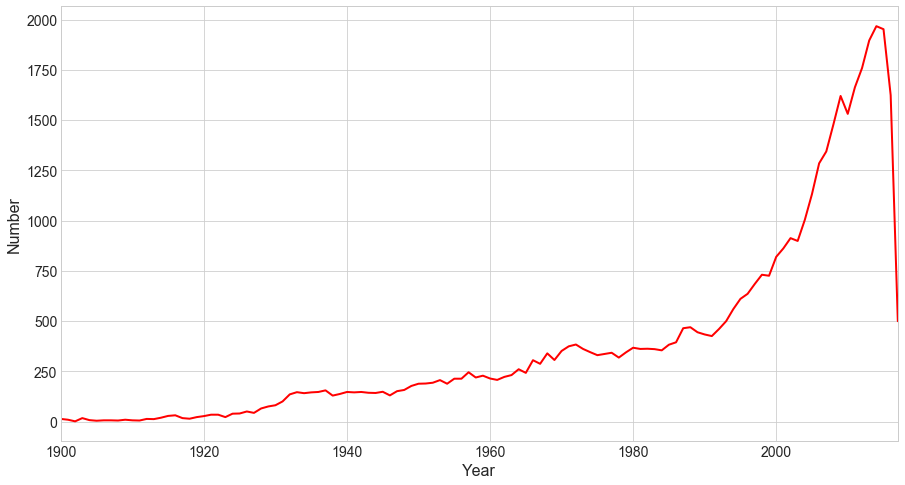

In [9]:
def plot_count(df,column):
    df.groupby(column).count()['title'].plot(figsize=(15,8),xlim=(1900,2017),fontsize=14,linewidth=2.0,c='r')
    plt.ylabel('Number',fontsize=16)
    plt.xlabel(column,fontsize=16)

plot_count(Movie,'Year')

## Take a look at the distribution of movie release years by genre

In [10]:
MovieGenre.columns = MovieGenre.columns.get_level_values(0)

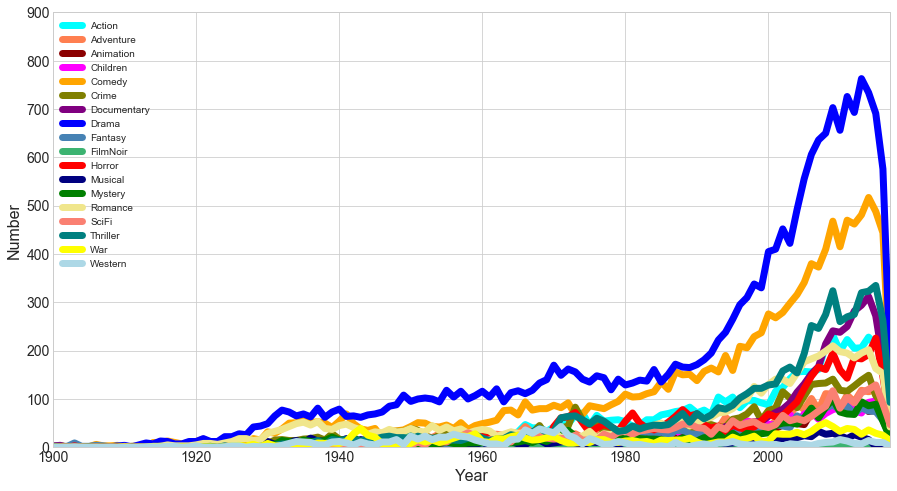

In [11]:
def plot_sum(df,column):
    df.groupby(column).sum()[GenreAll].plot(xlim=(1900,2017),ylim=(0,900),figsize=(15,8),color=c,linewidth=7.0)
    plt.ylabel('Number',fontsize=16)
    plt.xlabel(column,fontsize=16)
plot_sum(MovieGenre,'Year')

Drama and Comedy films clearly vastly outnumber all the other genres! The plot above only demonstrates the relative popularity of different genres over time. Now, I want to see the total number for each genre I am considering.m

## Next, examine the relative popularity of each genre overall

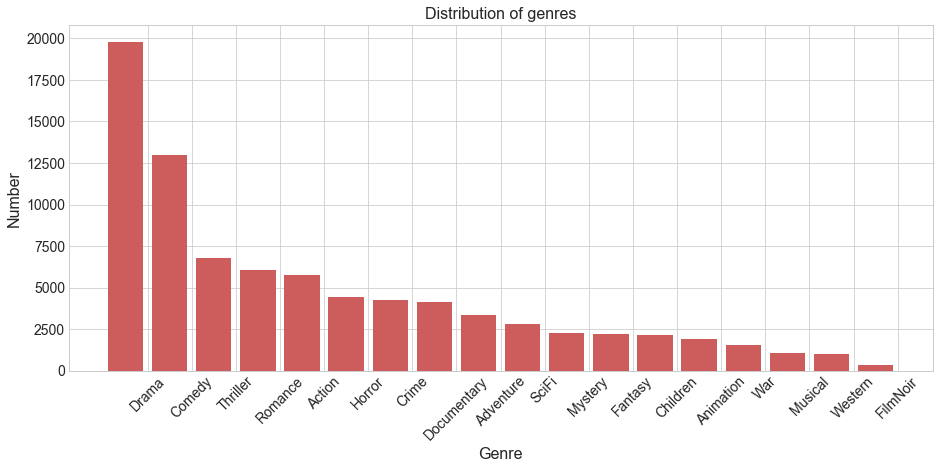

In [12]:
def relative(df):
    result = df[GenreAll].sum()
    x = np.arange(len(result.index))
    f = plt.figure(figsize=(15,6))
    ax = f.add_axes([0.1, 0.1, 0.8, 0.8])
    ax.bar(x, result.sort_values(ascending=False).values ,color='indianred')
    ax.set_xticks(x+0.5)
    ax.set_xticklabels(result.sort_values(ascending=False).index,rotation=45)
    plt.xlabel('Genre',fontsize=16)
    plt.ylabel('Number',fontsize=16)
    plt.title('Distribution of genres',fontsize=16)
    f.show()

relative(MovieGenre)

The above bar-plot shows the total number of movies for each genre. Drama and Comedy are the most dominant genres, which means that many people like watching movies of these genres, and so it is likely that producers try to make these types of films more frequently. Note that the total number of movies in the figure above is greater than the previous movie distribution plot because movies are counted multiple times if they have multiple genres. 

In [13]:
Rating.head(2)

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435


In [14]:
MovieRating = pd.merge(MovieGenre,Rating,on='movieId')
MovieRating.head(3)

,movieId,title,genres,Title,Year,Action,Adventure,Animation,Children,Comedy,...,Musical,Mystery,Romance,SciFi,Thriller,War,Western,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story,1995,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,4.0,1013443596
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story,1995,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,4.5,1073837180
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story,1995,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12,4.0,943912205


The above table shows the combined datasets when I merge the movie table with the users and their ratings. Now, it is possible to track users behavior in their ratings. So, one way I could explore potential bias in a user's ratings is  to assess whether a fan of a certain genre will rate movies of that genre higher/lower than the general public. First we need to define what is a fan of a genre.

In [15]:
final = data_featuring(MovieRating)

Do some feature engineering, like counts of genres reviewed for each user... 


## Going forward, only include users who are in the top 50,000 most active (in terms of number of movie ratings)

In [16]:
top = 50000
final_top = final.sort_values('TotalNumber',ascending=False).head(top)

## How can we define a group of fans for each genre? 

Selecting the fans for each genre is a tough mission. In this project, I define fans for each genre as people who reviewed the specific genre more frequently compared to movies of other genres.
For example, considering a person (person A) reviewed 1,000 movies in the dataset, and person A reviewed 300 SciFi movies out of the 1,000 they reviewed. I would consider person A to be a fan of SciFi (For the average person, SciFi movies only account for 6% of the movies they rated).

I will explain in detail in the charts below.

## <font color='darkred'> <** Fraction of ratings as a function of genre for each user **></font>

--------------------------
\begin{equation}
Fraction = \frac{\textrm{Number}\; \textrm{of}\; \textrm{movies}\; \textrm{for}\; \textrm{each}\; \textrm{genre}}{\textrm{Total}\; \textrm{number}\; \textrm{of}\; \textrm{movies}\; \textrm{rated}}
\end{equation}
--------------------------

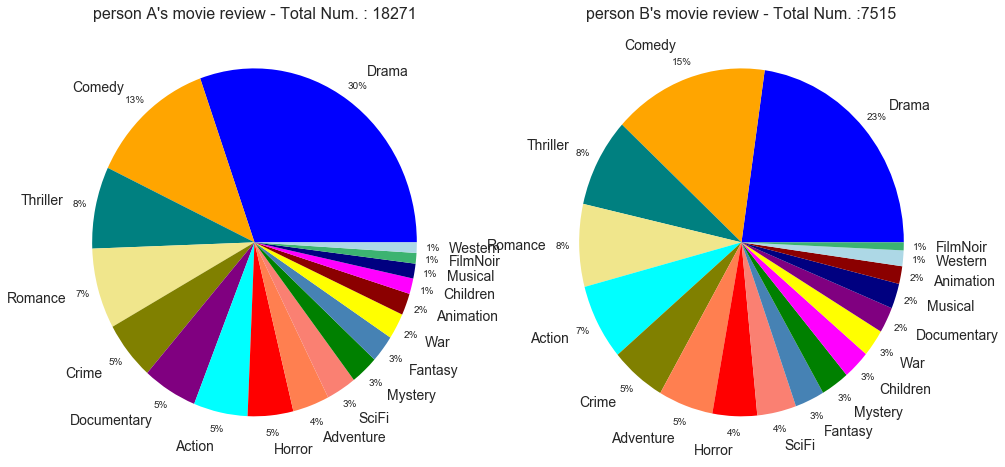

In [17]:
pie_fig(final_top[GenreAll],final_top['TotalNumber'])

The pie chart above is an example of two people's genre distributions for all the movies they rated. The reason why Drama and Comedy are more dominant than other genres is because there are many movies in these genres. The high fraction for drama and comedy does not neccesarily mean that they are fans of Drama or Comedy, but might simply reflect the fact that these genres are so prevalent. The charts above are pretty typical of an average users voting habits in the MovieLens database. 

Now, let's look at a few outliers. The chart below shows the rating distributions for people who appear to be fans of Horror movies.

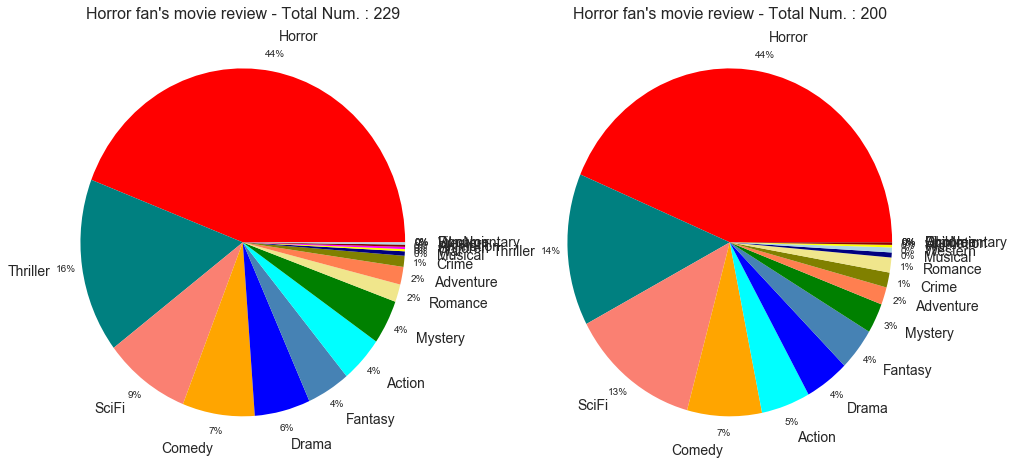

In [18]:
pie_fig_horror(final_top,final_top[GenreAll],final_top['TotalNumber'])

**Note that the UNUSUAL Horror fans rated far fewer movies than typical users in my samples.**
As seen in the chart above, the distribution is very different from the previous plots. In the case of these people, I will consider them to be fans of horror movies. 

I selected fans of each genre following the steps below:

1. Start by looking at the relative fraction of ratings by genre for the overall population. Then, it stands to reason that someone who is a fan of a certain genre, and who watches a disproportionately large fraction of movies in that genre, would rate movies in that genre more frequently than the average person does.

2. Look for outliers who rated movies of that genre at a much higher frequency than the overall population.

The box-plot below shows the typical range of percentages of certain genres that users reviewed.

Text(0.5,1,'Percent of reviews by genre for every user')

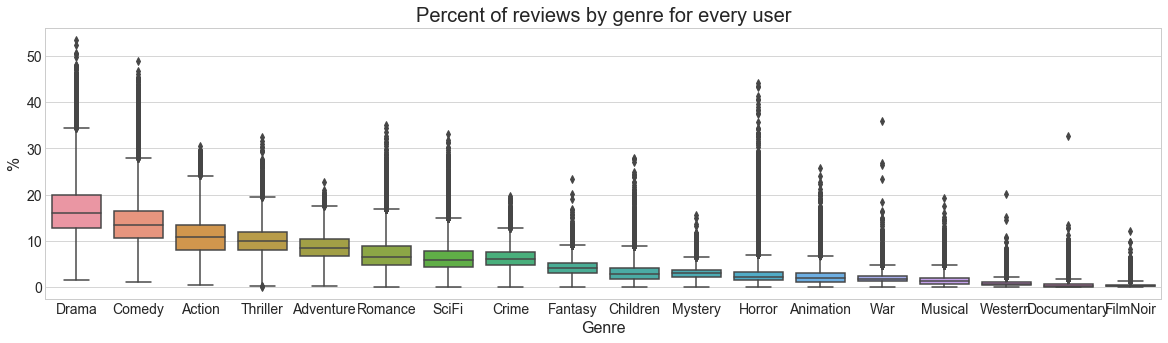

In [19]:
plt.figure(figsize=(20,5))
sns.boxplot(data=final_top[GenreAll]*100,orient='v',
            order=final_top[GenreAll].sum().sort_values(ascending=False).index,
           whis=2)
plt.ylabel('%',fontsize=16)
plt.xlabel('Genre',fontsize=16)
plt.title('Percent of reviews by genre for every user',size=20)

The colored boxes in the box-plot above highlight the 25%-75% range of the distribution for each genre that people reviewed. The upper whiskers corresponds to the top 1% of the distribution. 
Based on this information, I consider a fan to be a person who is identified as an outlier above the upper whiskers for each genre. For example, if someone has rated drama movies at more than 35%, I would define this person as a fan of drama (Look at the box graph for drama). Therefore, I chose 500 people (1% of total sample of 50,000) for each genre as the group of fans for that genre. 

**The following cleaning steps take a while to run, so I comment them out after running and saving the output.**

In [20]:
#top30_find(final_top,MovieRating)

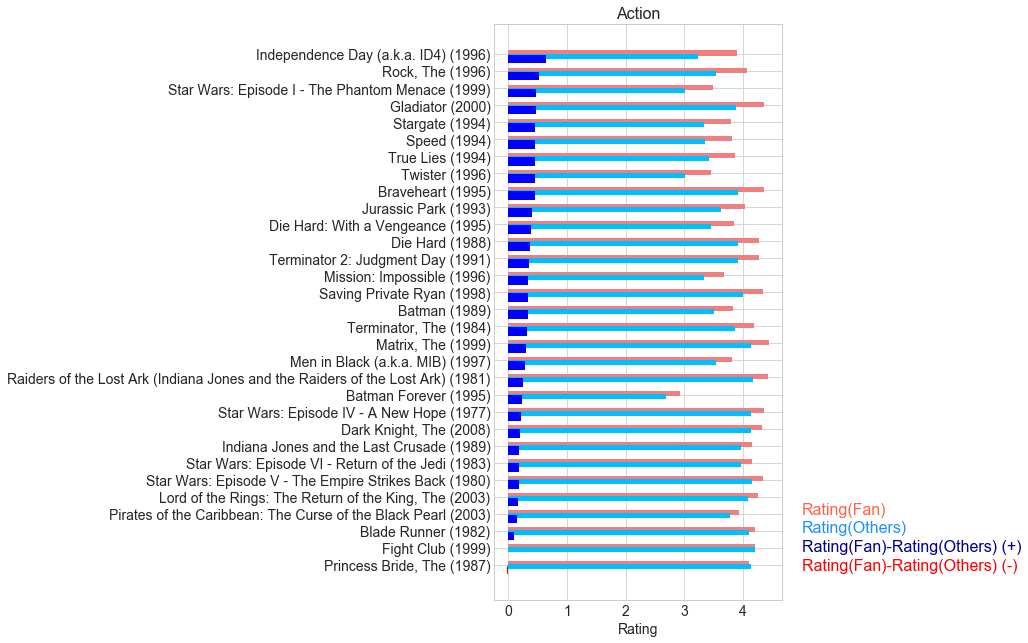

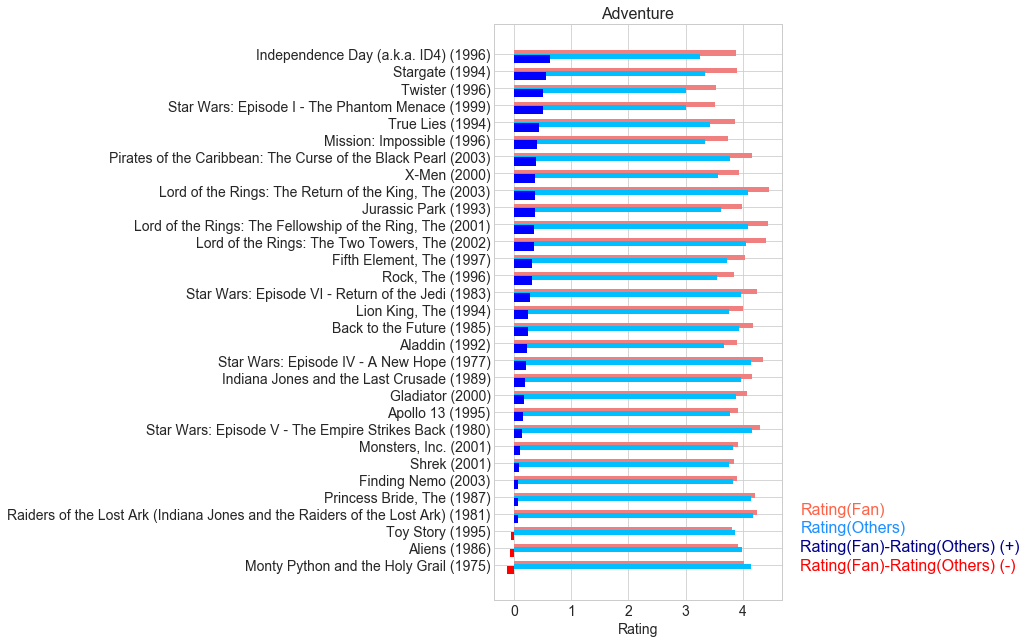

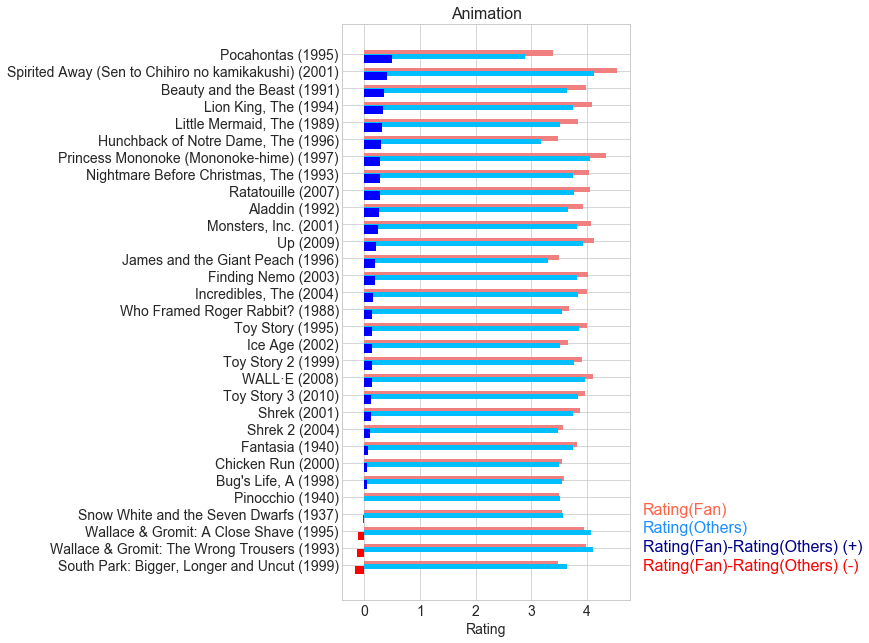

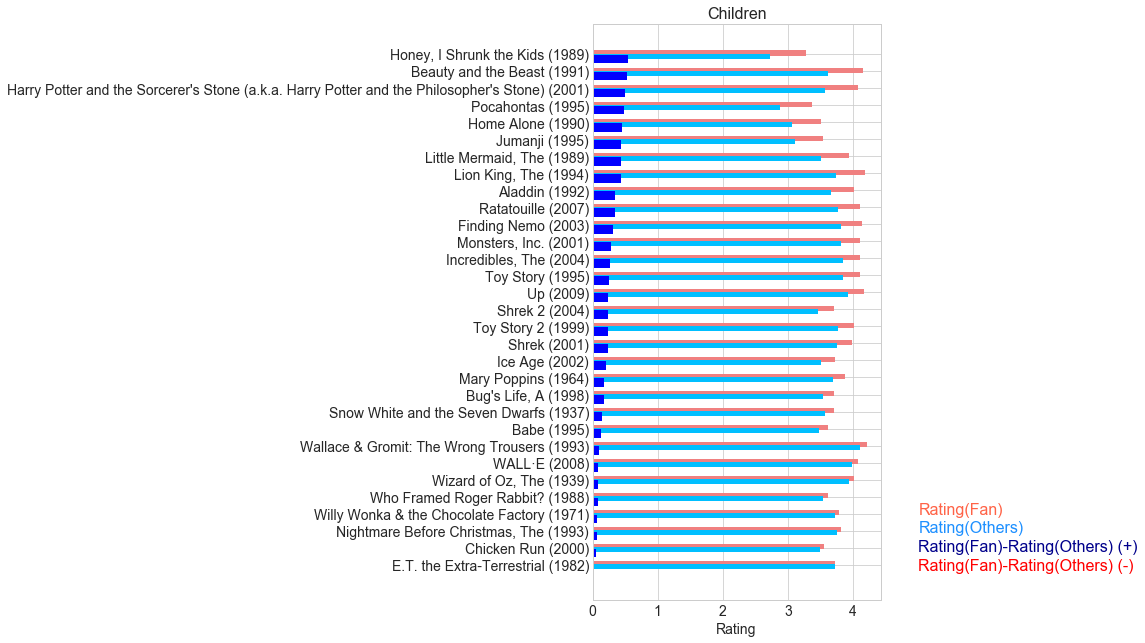

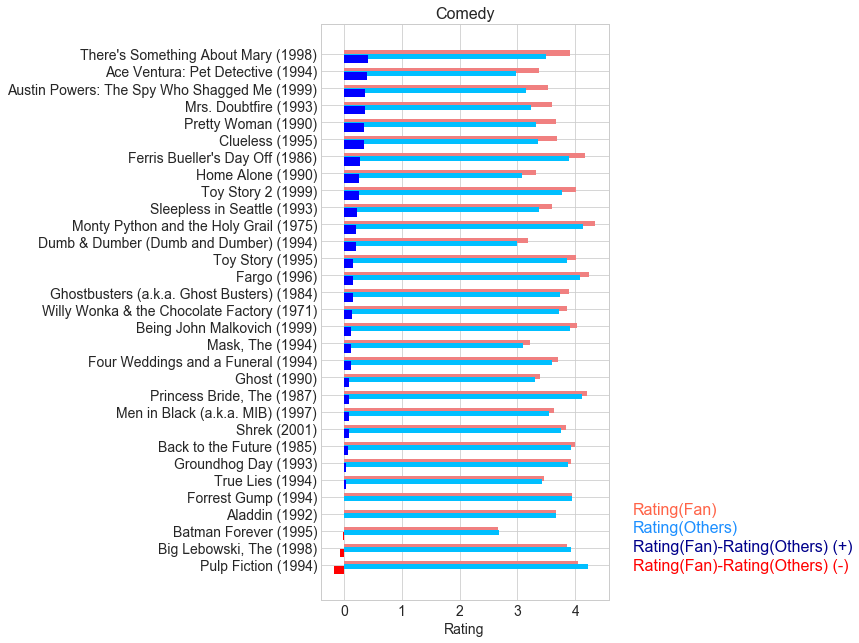

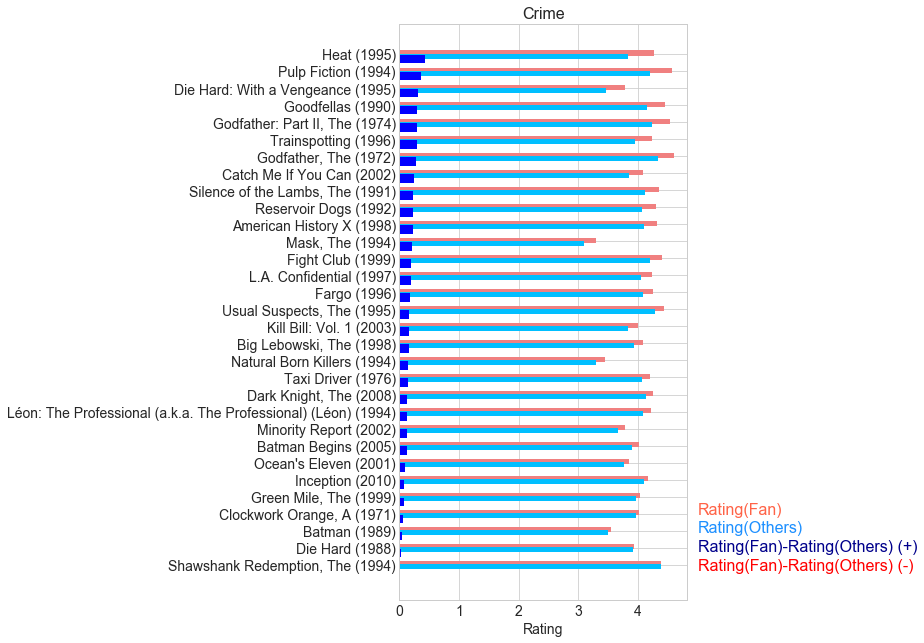

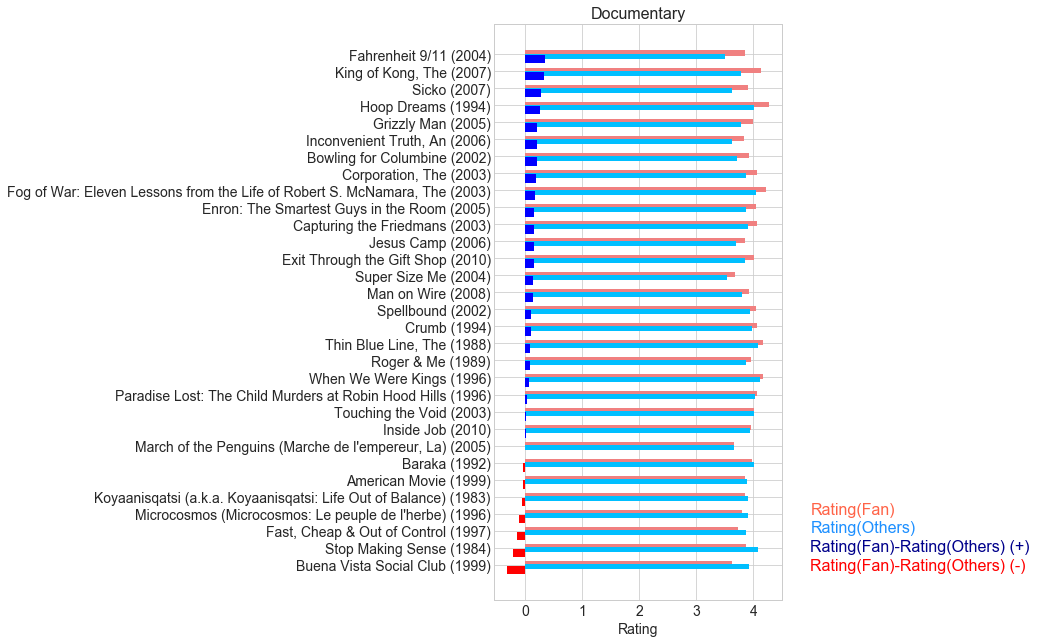

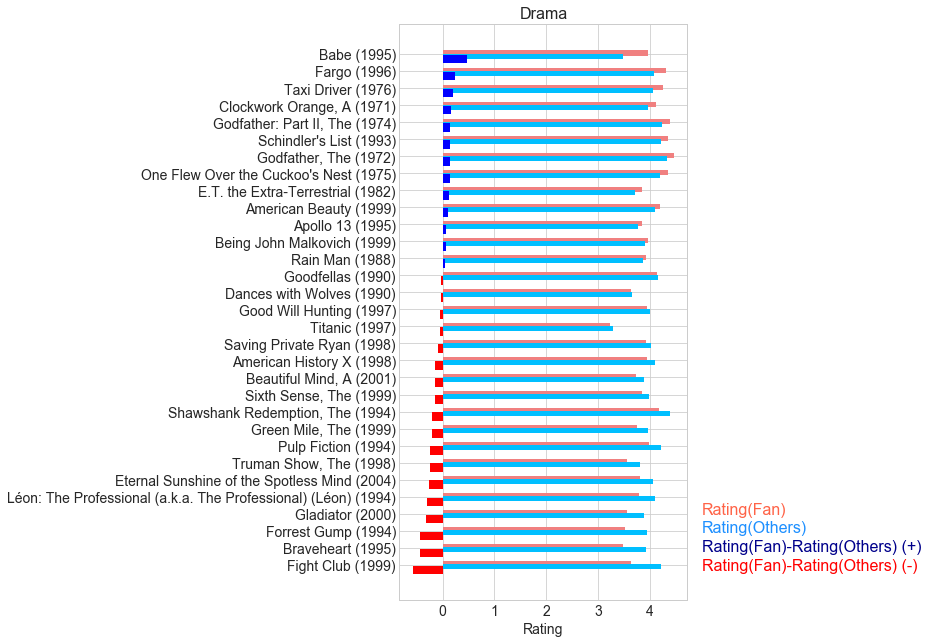

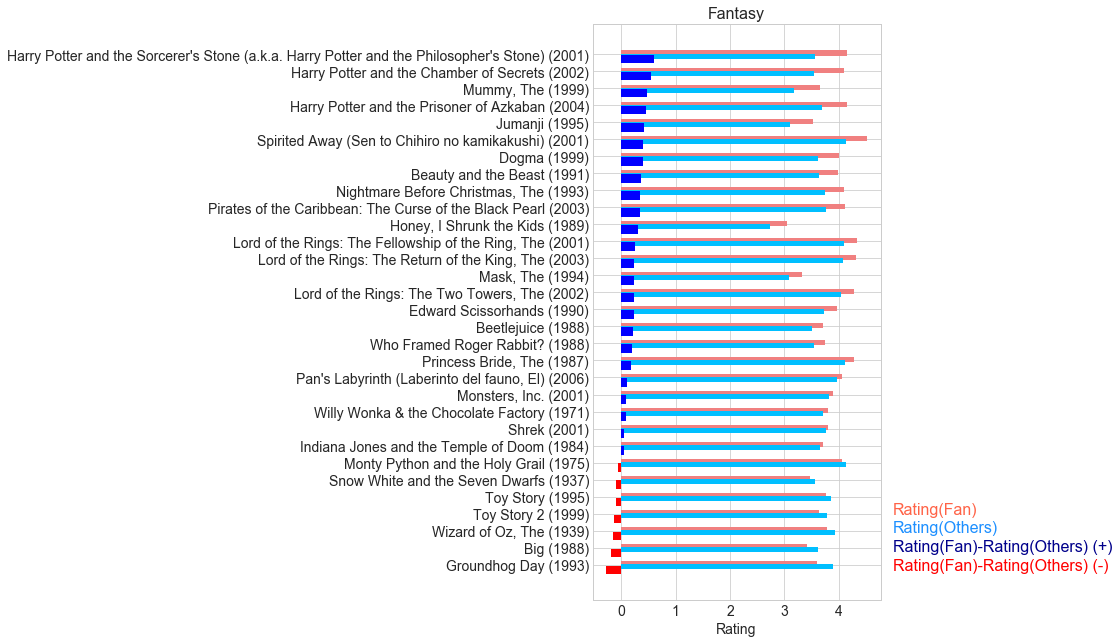

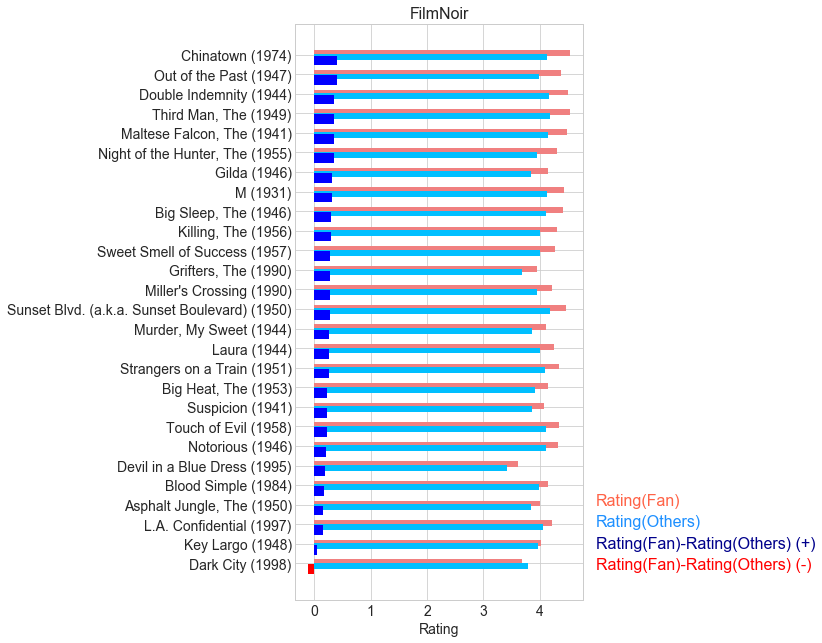

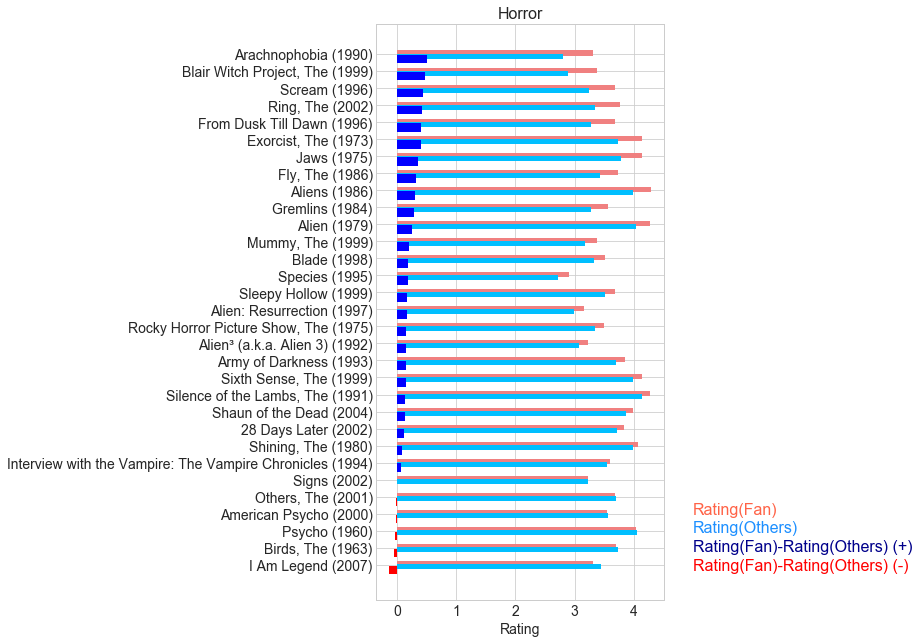

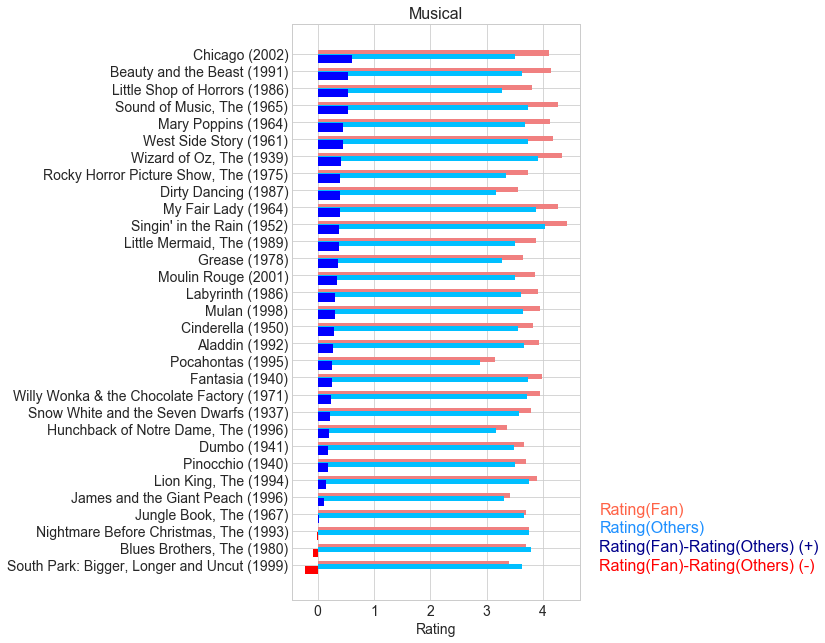

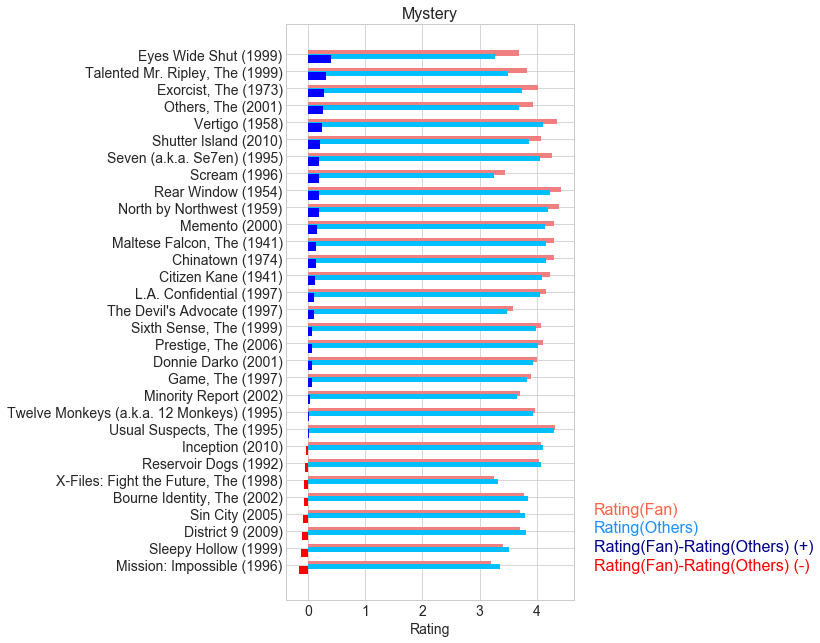

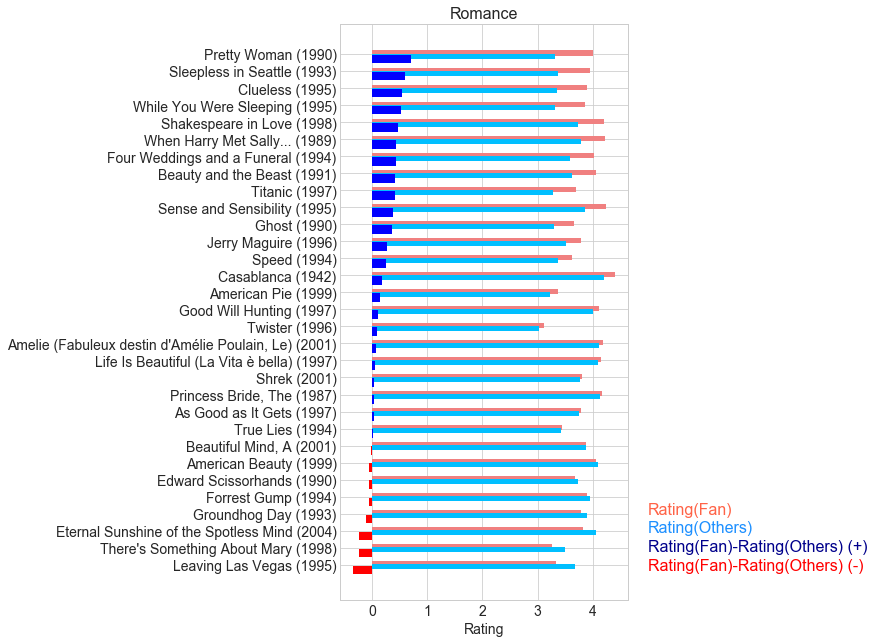

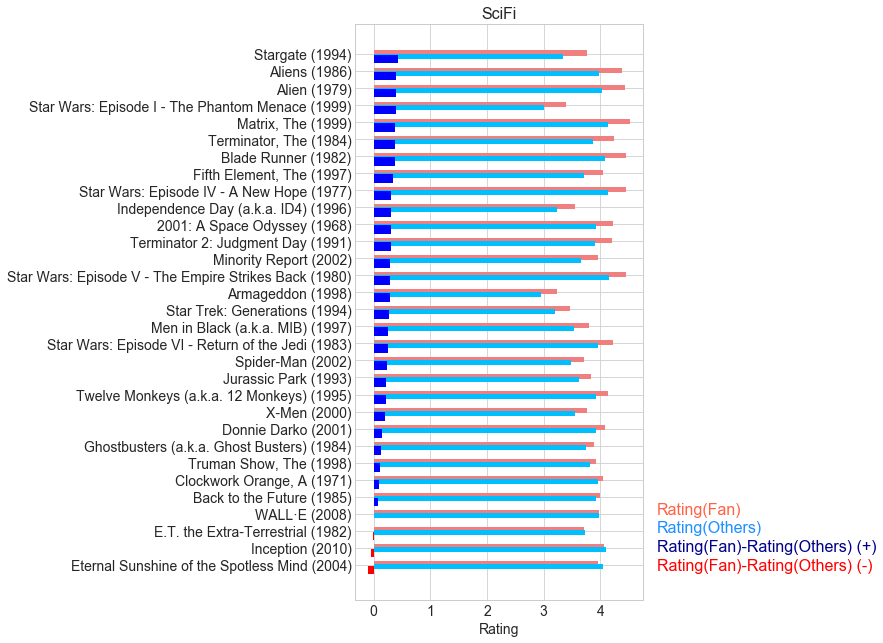

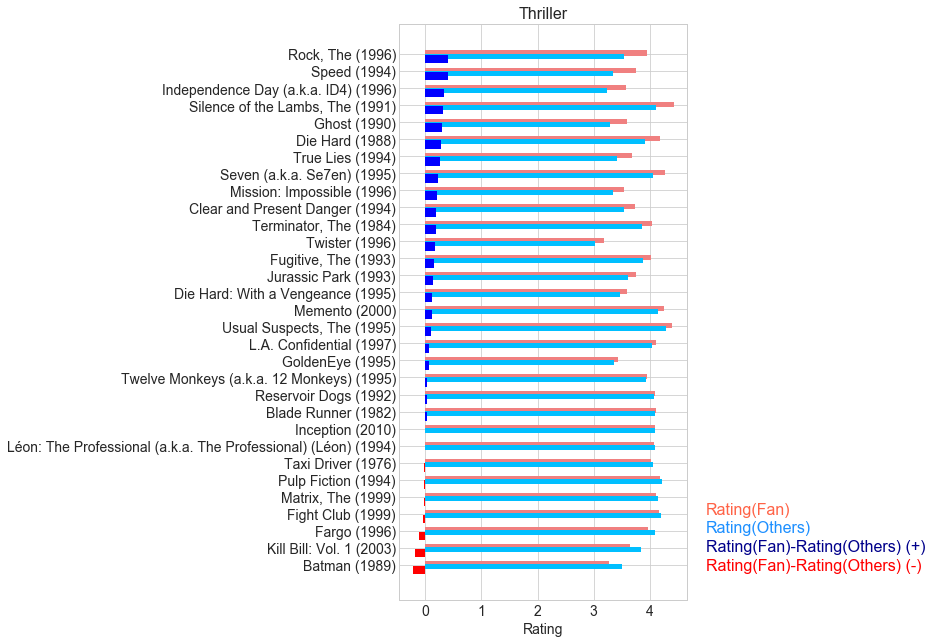

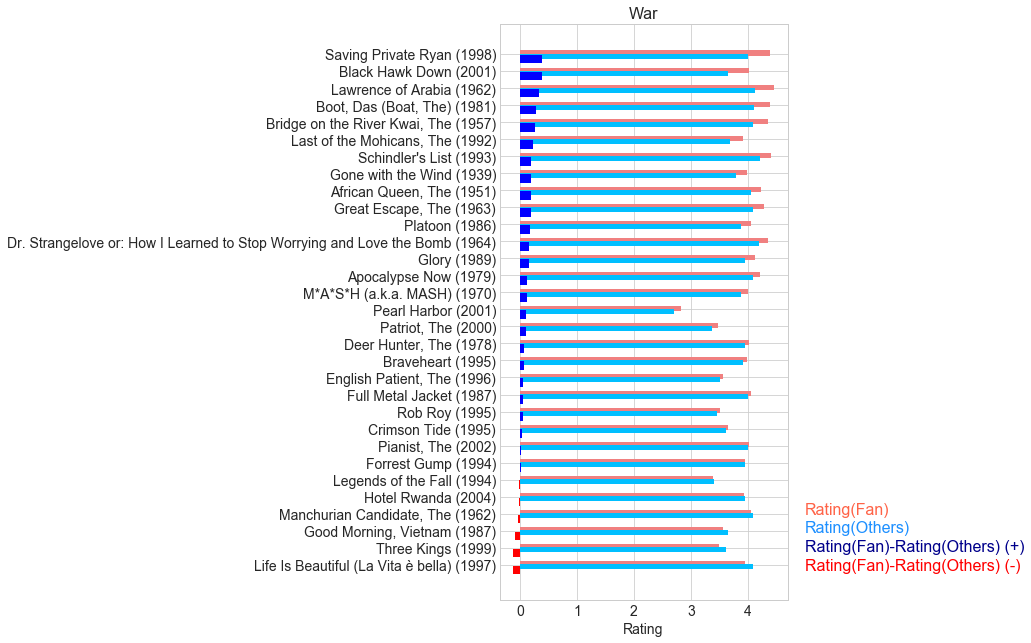

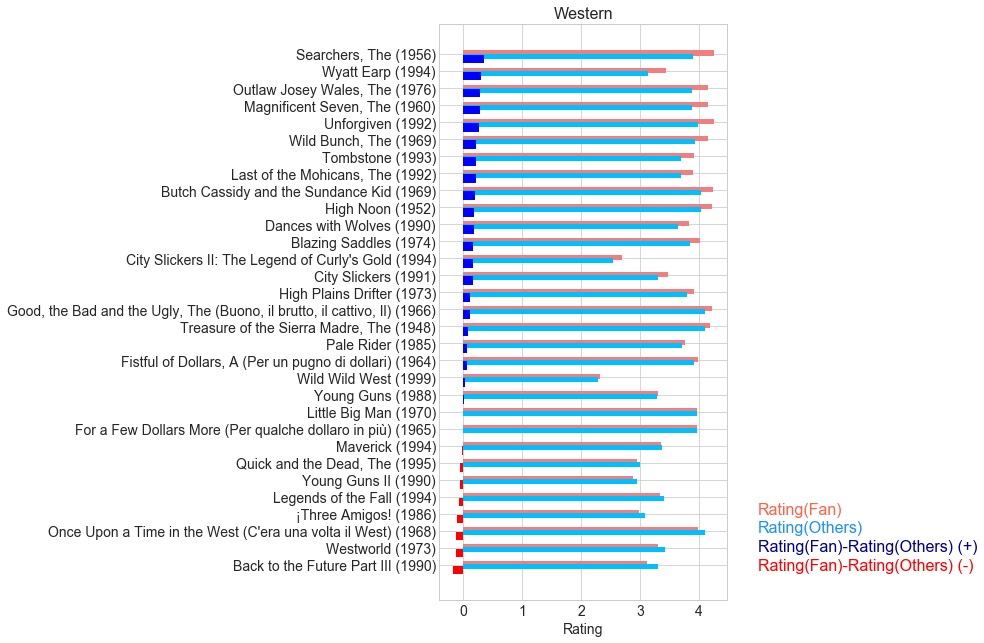

In [21]:
for i in GenreAll:
    name=i
    top30 = pd.read_csv(name+'.csv').T
    top30.columns = top30.columns.get_level_values(0)
    top30_plot(top30,name)
#    plt.savefig(name+'_plot.png')

From the figures above, it is clear that many movies overlap between different genres (**See the figures below**) and it is not always that easy to separate very similar genres from each other. Therefore, the best approach to analyze movie preferences might not be to try to separate each genre from each other genre, but to allow for correlations between genres to be included in the analysis. In the following section, I will explore an alternate technique using **Principal Component Analysis (PCA)** and **K-means clustering**.

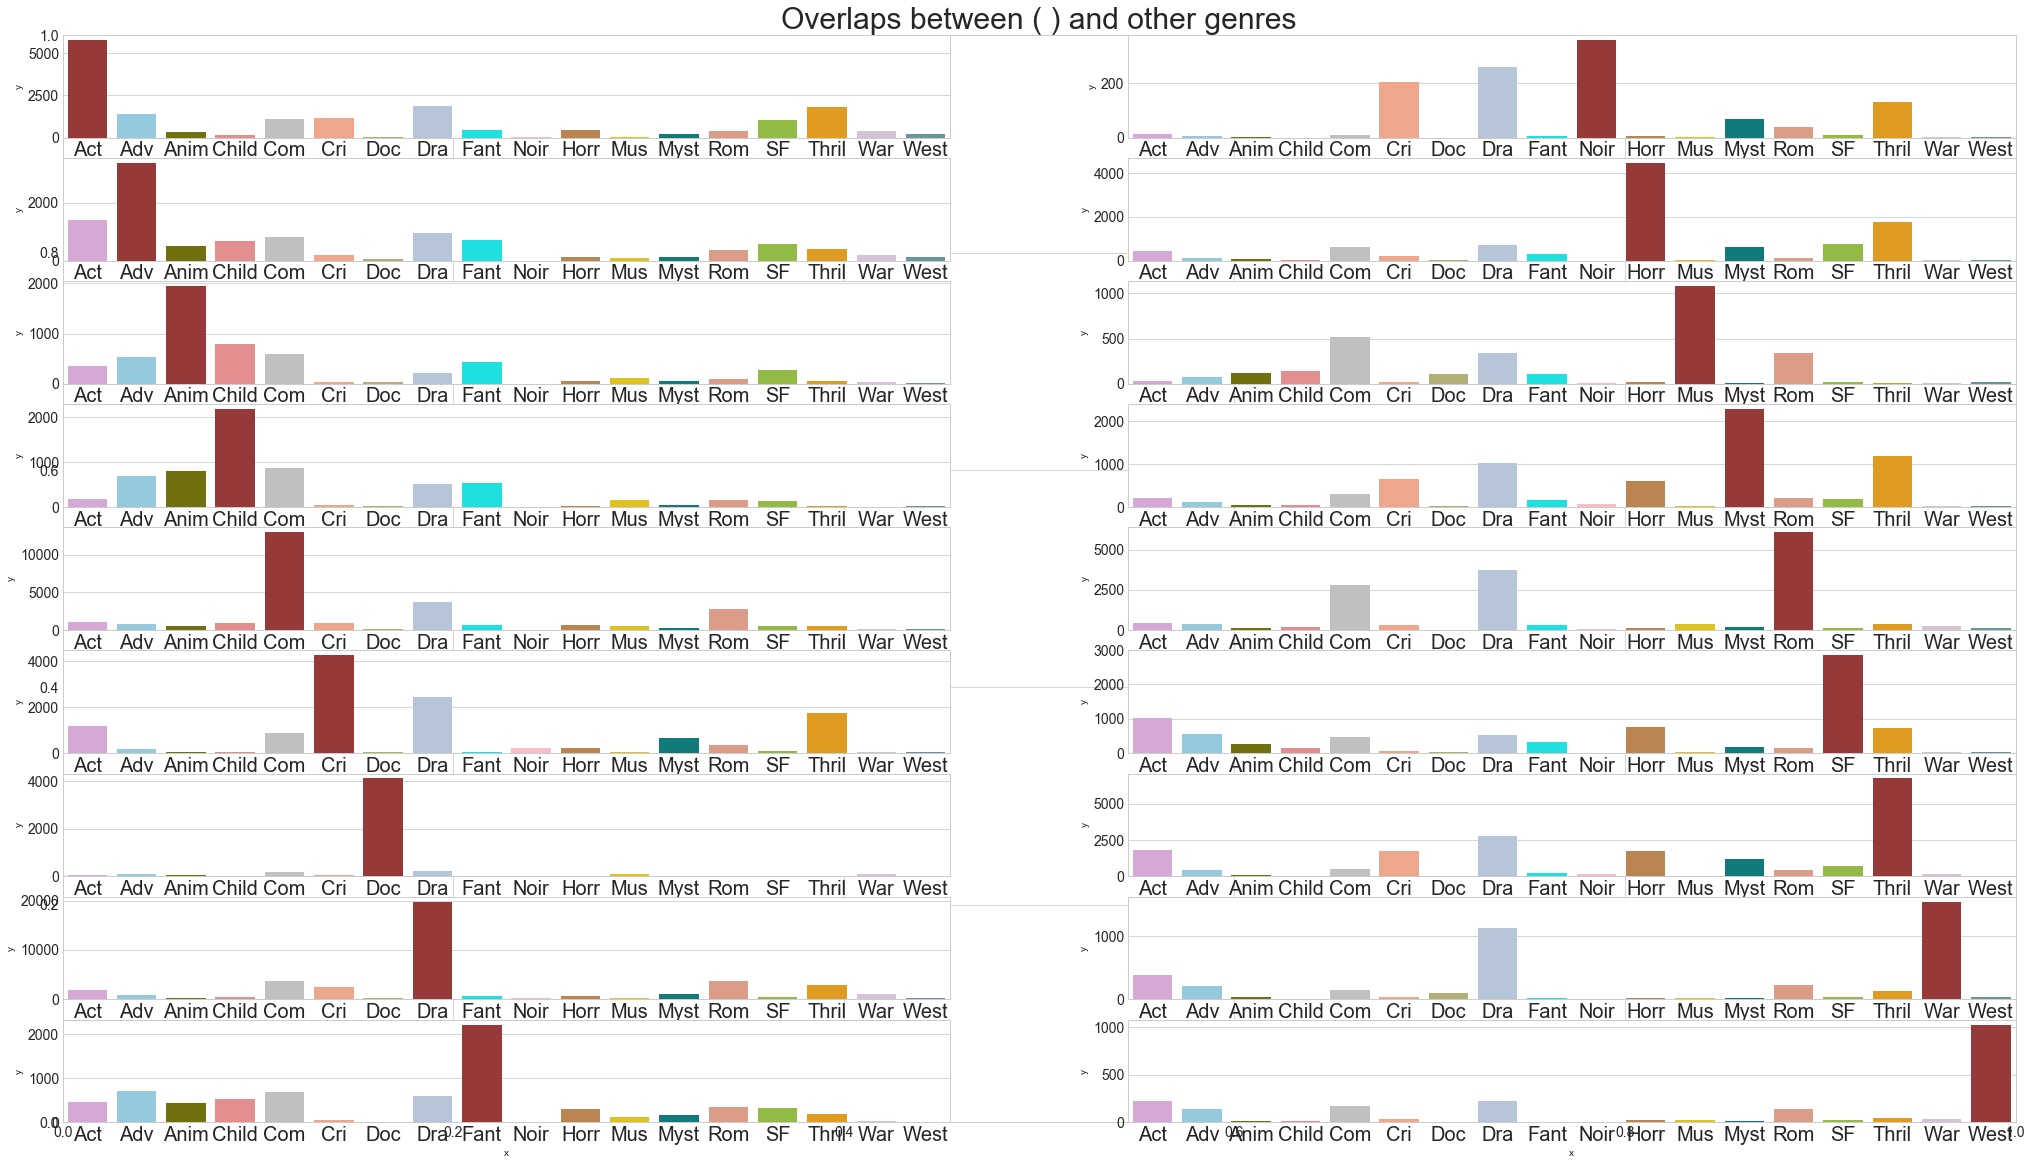

In [22]:
overall_plot(MovieGenre)

## Let's examine any correlations between the ratings of different genres

Text(0.5,1,'Correlation')

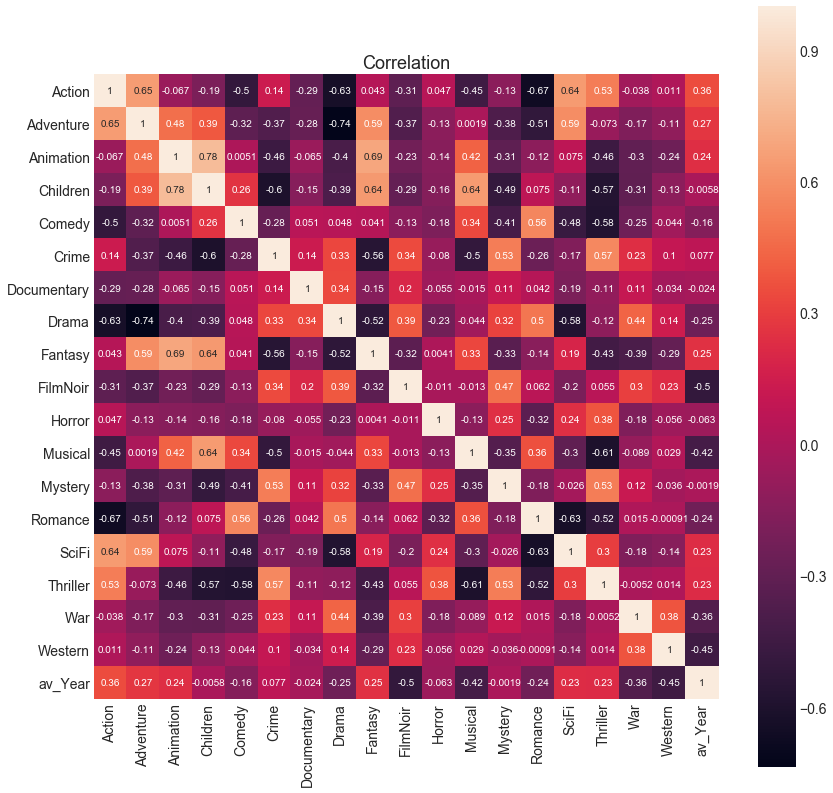

In [23]:
corr = final_top[incl_year].corr()
plt.figure(figsize=(14,14))
sns.heatmap(corr, vmax=1, square=True,annot=True)
plt.title('Correlation',fontsize=18)

### The correlation matrix heatmap above reveals some fundamental characteristics of movies and user preferences that are worth explaining, namely:

- **Strong correlations** exist between: 
 - Action & Adventure
 - Action & SciFi
 - Animation & Children
 - Animation & Fantasy
 - Adventure & Fantasy
 - Children & Fantasy
- **Strong anti-correlations** exist between:
 - Action & Drama
 - Action & Romance
 - Adventure & Drama
 - Children & Crime
 - Musical & Thriller
- Correlations and anti-correlations with **av_Year** shows which genres tend to be more common in recent years (Action, Adventure, Fantasy, SciFi, and Thriller) and which genres had their heyday in the past (Film Noir, Musical, War, and Western), respectively.

### Let's examine the genre preferences in a more quantitative statistical way, using Principal Component Analysis (PCA)

I take the matrix of users (rows) and number of reviews by genre (columns) and perform a decomposition of that matrix into the sum of eigenvectors times corresponding eigenvalues. This has the effect of re-casting the matrix into a set of orthogonal axes, and when I sort those eigenmodes from the largest (absolute value) eigenvalue to smallest, the first couple of eigenmodes each correspond to the axes along which we find the greatest variance in our data. 

The result, plotted blow for the top two eigenmodes, shows how each of them naturally corresponds to some of the most fundamental divides between user preferences in genres (where we see weights of some genres having similar or opposing signs)

In [33]:
#pca_plot(final_top[incl_year],2)

<img src="img/pca_poster.jpg">

The **upper-left** of the figure above corresponds to strong weights for Action, Adventure, Fantasy, and SciFi, while the **lower-left** features the strongest weights for Drama and Romance. This dichotomy represents the most significant single divide in the user movie preferences, and it's surely one of the most obvious broad divides between types of films. 

The **upper-right** is dominated by Children, Musical, Animation, and Romance while the **lower-right** is Thriller, Crime, Action, and Mystery. This second dimension apparently separates light-hearted films aimed at children from more gritty, often violent movies geared towards adults.

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,FilmNoir,...,av_FilmNoir,av_Horror,av_Musical,av_Mystery,av_Romance,av_SciFi,av_Thriller,av_War,av_Western,av_rating
group,,,,,,,,,,,,,,,,,,,,,
0,0.121798,0.074785,0.011178,0.013910,0.103492,0.085561,0.002681,0.178022,0.030060,0.004149,...,4.0,3.453488,3.500000,3.758940,3.578431,3.486206,3.616709,3.833333,3.700000,3.618106
1,0.155136,0.111298,0.022364,0.025899,0.100719,0.060519,0.001304,0.118255,0.045872,0.001784,...,4.0,3.480769,3.500000,3.756579,3.561644,3.596154,3.637097,3.821429,3.666667,3.625749
2,0.064558,0.072368,0.026075,0.044966,0.188621,0.043248,0.002569,0.181914,0.045097,0.001914,...,4.0,3.277778,3.707547,3.675000,3.655364,3.416667,3.500000,3.816986,3.500000,3.594425
3,0.107966,0.084854,0.020833,0.030475,0.144312,0.061433,0.002770,0.160926,0.041636,0.002570,...,4.0,3.333333,3.530931,3.642857,3.516539,3.414912,3.491452,3.775000,3.500000,3.517026
4,0.109596,0.114775,0.046154,0.060785,0.145204,0.037975,0.001369,0.112133,0.063457,0.000648,...,4.0,3.351602,3.661290,3.673691,3.605263,3.571429,3.548387,3.785714,3.562500,3.582768
5,0.066038,0.053016,0.010782,0.017585,0.148300,0.070028,0.005780,0.243304,0.028436,0.006817,...,4.0,3.447368,3.666667,3.750000,3.665394,3.420000,3.600000,3.875000,3.666667,3.659935


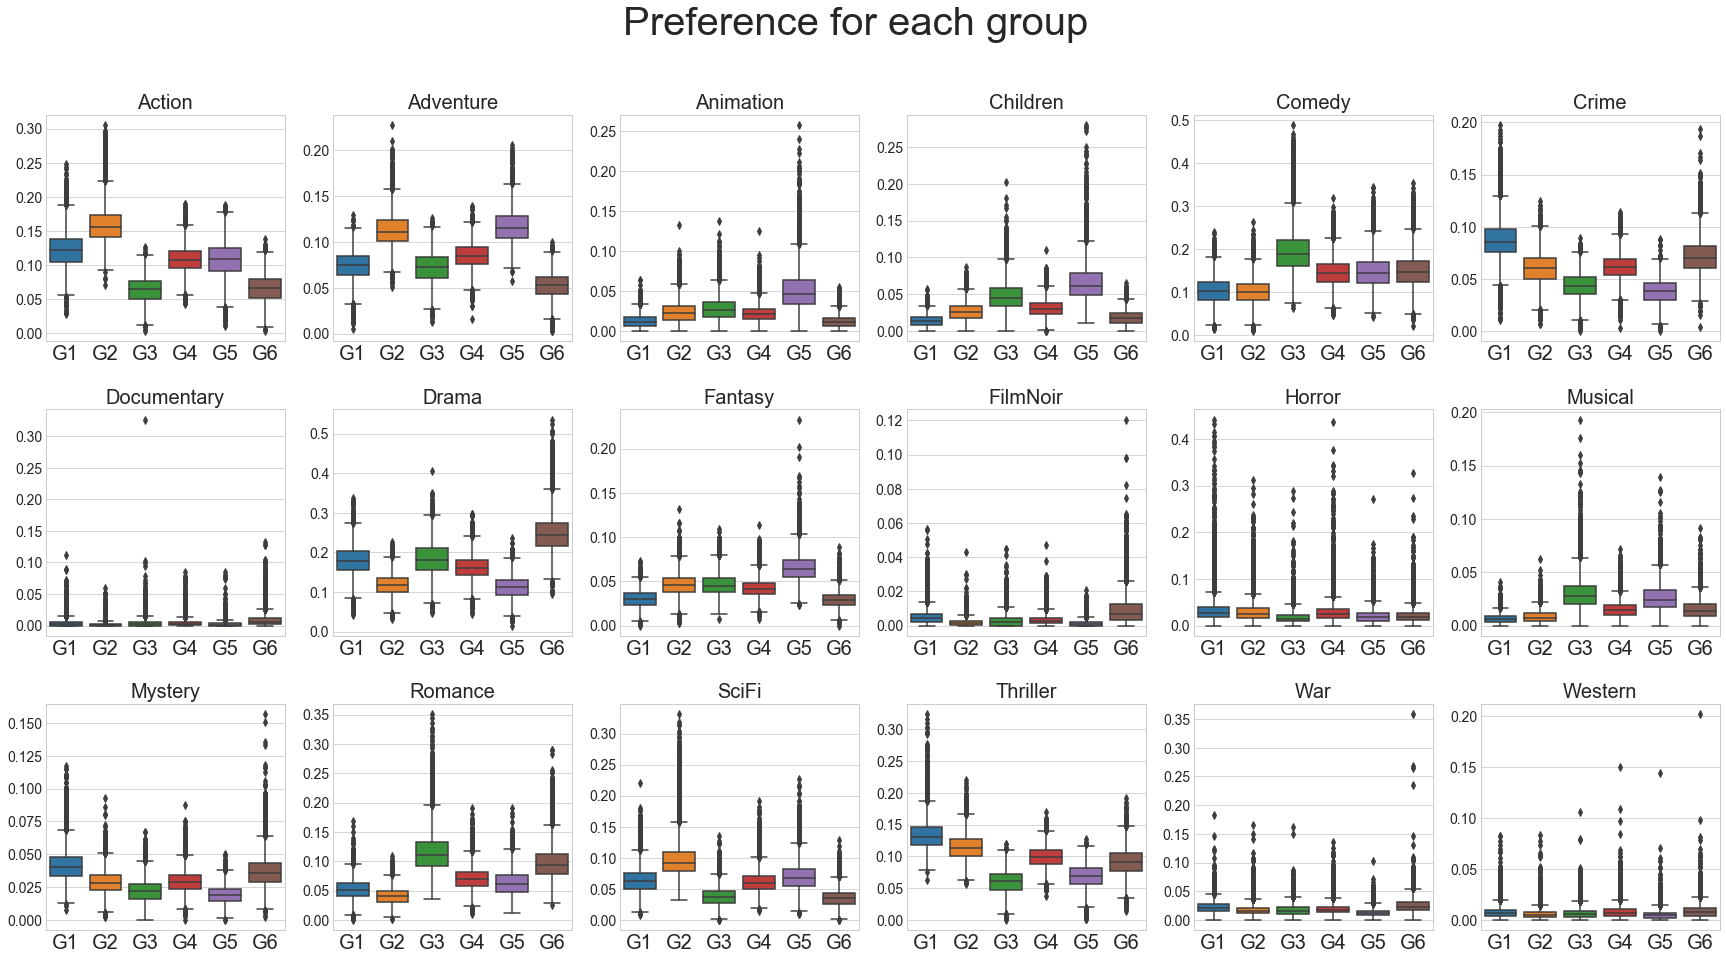

In [142]:
#reduced_data = pca_function(final_top[incl_year],2)
#check_kmean(reduced_data,8)
#kmeans = KMeans(n_clusters=6,random_state=2300).fit(reduced_data)
#final_top['group'] = kmeans.labels_
#reduced_data['group'] = kmeans.labels_
#new = final_top.groupby('group').median()
new.to_csv('dist.csv')

fig = plt.figure(figsize=(30,15))
fig.suptitle("Preference for each group", fontsize=40)
for i in range(len(GenreAll)):
    ax = fig.add_subplot(len(GenreAll)/6,6,i+1)
    sns.boxplot(data=final_top,x='group',y=GenreAll[i])
    ax.set_xticklabels(['G1','G2','G3','G4','G5','G6'], rotation=0, fontsize=20)
    plt.ylabel('',fontsize=10)
    plt.xlabel('',fontsize=10)
    plt.title(GenreAll[i],fontsize=20)
plt.subplots_adjust(hspace=0.3,wspace=0.2)
#fig.tight_layout()

- <font color='darkblue'> Group 1 <strong>(Action Police)</strong>: Crime, Thriller, Mystery </font>

- <font color='darkorange'> Group 2 <strong>(Blockbuster Action)</strong>: Action, Adventure, SciFi </font>  

- <font color='green'> Group 3 <strong>(Rom-Com)</strong>: Comedy, Drama, Romance, Musical </font>

- <font color='red'> Group 4 <strong>(General)</strong>: ... </font>

- <font color='purple'> Group 5 <strong>(Light Hearted Family)</strong>: Adventure, Animation, Children, Fantasy </font>

- <font color='brown'> Group 6 <strong>(Gritty Crime Drama)</strong>: Documentary, Drama, FilmNoir </font>

**The following cleaning steps take a while to run, so I comment them out after running and saving the output.**

In [34]:
#MovieRatingShort = MovieRating[['title','userId','rating']]
#group_final = pd.DataFrame(columns=['genre','title','group','Number','mean'])
#n=0
#for i in range(len(GenreAll)):
#    name = GenreAll[i]
#    top30 = pd.read_csv(name+'.csv').T
#    top30= top30_cleaning(top30,name)
#    movie_name = top30.index
#    for j in range(len(movie_name)):
#        submovie = MovieRatingShort[MovieRatingShort['title']==movie_name[j]]
#        for k in range(6):
#            user_index =pd.DataFrame(final_top[final_top['group']==k].index)
#            user_submovie = pd.merge(submovie,user_index,on='userId')
#            count = len(user_submovie)
#            mean = user_submovie.rating.mean()
#            group_final.loc[n]=[name,movie_name[j],k,count,mean]
#            n+=1
#        print(name+' :'+str(j)+' : '+movie_name[j])
#group_final.to_csv('result_pca.csv')

In [66]:
result_pca = pd.read_csv('result_pca.csv')
result_pca.drop('Unnamed: 0',axis=1,inplace=True)
#name='Drama'
#top30 = pd.read_csv(name+'.csv').T
#top30= top30_cleaning(top30,name)
#top30.index
#result_pca_plot(result_pca,'Fargo (1996)',name)

<img src="img/comp_drama.jpg">

These two dramas above demonstrate the really broad range of films that can be called **drama**. Titanic is much more of a Romance & Adventure Drama, while Fargo is focused on a Criminal Investigation.

<img src="img/comp_thriller.jpg">

The Silence of the Lambs is a Thriller which has strong Horror and Criminal elements, which is why it is preferred by G1 and G6 in particular. Meanwhile, Die Hard is primarily an Action Thriller that is well-liked by G2.

<img src="img/comp_adventure.jpg">

In the Adventure genre, there is a very wide range of films that span from light-hearted movies for Children, like Aladdin, to much darker and Action-packed films like Aliens.

<img src="img/comp_music.jpg">

In Musicals, there is likewise a split between the films intended for adults, like Chicago, and those geared towards children, like the Lion King.

## Conclusions

I have examined the ratings that people give to movies, and how those ratings might be biased by people's preferences for certain kinds of movies. It is clear that distinct biases exist based on one's movie preferences. To study these biases more quantitatively, I first used a simple approach that treated each genre independent of each other, but I also clearly found evidence of strong correlations (and anti-correlations) between some genres. So a more rigorous approach was taken to study user preferences which allowed for the inherent correlations between genres to be included by using PCA. 

The PCA analysis reduced the available features to just two dimensions, corresponding to the two most significant eigenmodes that contribute to the variance in the data. From these two dimensions, I selected six distinct clusters using the unsupervised learning algorithm called KMeans clustering. After checking the different ratings given by users in these six clusters, a pattern emerges that reveals some of the most fundamental divides in movie preferences. 